# DSCI 100 Final report: Can played hours, participant age, and experience predict if a participant is subscribed to a gaming related newsletter?

## Amisha, Rocco, Sophie, Uday

In [13]:
#run this code to read players.csv data 
library(tidyverse)
library(repr)
library(tidymodels)

players_data <- read_csv("https://raw.githubusercontent.com/roccopbug/dsci_100_group_7_004/refs/heads/main/data/players.csv") 

head(players_data)

#to see how many observations we have without printing the whole dataset
nrow(players_data)

#to see what are the different options of experience, group by, then summarize
experience_counts <- group_by(players_data, experience)|>
    summarize(count = n())

#experience_counts

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


[1] 196

### Introduction:
The Pacific Laboratory for Artificial Intelligence (PLAI) at UBC is collecting data from a Minecraft server to train and develop an advanced AI model. PLAI collected data based on participants playing habits on the server. We will be analyzing the players dataset, using k-nn classification to see if participant age and played hours is able to predict whether or not the participant is subscribed to a gaming related newsletter. Specifically, we're interested to see whether or not our k-nn model will be able to predict the correct category 90% of the time or more with the optimal K.

- Participants of all ages and skill level were included.
- Data was collected on an excel spreadsheet.
- There are 196 observations, meaning we have 196 players' data in players_data
- 7 variables (experience, subscribe, hashedEmail, played_hours, name, gender, age) 
#### Data Description: players.csv 

| Variable      | Type      | Meaning                                      |
|----------------|-----------|----------------------------------------------|
| experience     | factor    | Playing experience of player in MineCraft. Either  Amateur, Beginner, Regular, Pro, or Veteran
| subscribe      | logical   | States if player is subscribed to a game related newsletter (true or false) |
| hashedEmail    | character | Email used by player in MineCraft                               |
| played_hours   | double    | Total hours played by player                        |
| name           | character | Name of user                                 |
| gender         | factor    | Gender of user                               |
| age            | integer   | Age of user (years)                          |





**Issues in Dataset**
- Some variables are not relevant in the dataset in relation to our question, such as hashEmail. This dataset  will need to be tidied before using. 
- Some players in the dataset chose to not specify their gender. This can cause issues if gender is used as a variable in answering a question, since plots or averages can be inaccurate. 
- There may be outliers in the dataset which will vastly effect how k-nn works. If this becomes an issue, we can either remove extreme outliers, or implement a logarithmic scale to our variable
- Inconsistency in the variable names, such as "Age" being capitalized.
- Order of which data is read in (order of variables).


**Broad Question**
- Can a k-nn model, accurately predict a players' subscription status by using certain variables in players.csv?


**Specific Question**
- Can hours played, and age predict whether a MineCraft player subscribes to the game's newsletter?

**How the Dataset Will Help Answer This Question**
- The dataset shows whether each individual is subscribed to the newsletter
- Players hours played reflects on how often a player engages with the game, and can be analyzed the same way as players experience is, with a graph
- Players age may reflect how interested different age groups are in the game, and can be analyzed the same way.
- These are 2 numeric variables which, in a simple manner tell us a lot about our participants

**How to Wrangle the Dataset**
- Select variables specific to the question being answered (subscribe, played_hours, age)
- Tidy the dataset by naming variables in similar matter (all lowercase)
- Split the data into a training and testing dataset  

### Methods and results:
**KNN classification is the most appropriate method to answer this question**
- this is because we are predicting a true/false variable instead of a numeric one
- predictions on non-linear relationships can be made, which is the case for this question

**Selecting and composing a model**
- Tune different k values by testing a number of k values to see which is most accurate
- Use cross validation
- Use age and hours played as predictors
- Prediction is true/false for subscribe, whether or not the participant is subscribed to a game related newsletter
- After tidying the data, split data in 75/25 format (75 for training, 25 for testing)
- Use k fold cross validation and determine a suitable k value 

In [15]:
#run this code to read tidy data 


players_data_tidy <- players_data |>
    select(subscribe, played_hours, Age)|>
    #select(name, gender, Age, played_hours, experience, subscribe, -hashedEmail, -gender) |>
    rename(age = Age) |>
    mutate(subscribe = as_factor(subscribe))
    #arrange(age) this isn't 100% necessary?

head(players_data_tidy)

sub_pct <- group_by(players_data_tidy, subscribe)|>
                summarize(prop = n()/nrow(players_data_tidy))
sub_pct #very skewed, way more TRUE

subscribe,played_hours,age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


subscribe,prop
<fct>,<dbl>
FALSE,0.2653061
TRUE,0.7346939


Now, compute summary statistics to get a sense of the center/mean of our data

In [3]:
#Compute mean value for each quantitative variable and report mean values in table format 
summary_mean <- players_data_tidy |>
    summarize(mean_age = mean(age, na.rm = TRUE),
              mean_played_hours = mean(played_hours, na.rm = TRUE))

summary_table <- summary_mean |>
    pivot_longer(cols = everything(), 
                 names_to = "variable", 
                 values_to = "mean")

players_means <- summarize(players_data_tidy, #this is how i did it, i dont think summary table is tidy
                                               #since a collumn is just a label/key not a variable
                            mean_age = mean(age, na.rm = TRUE),
                            mean_played_hours = mean(played_hours, na.rm = TRUE))|>
                                mutate(mean_age = round(mean_age, 2),
                                       mean_played_hours = round(mean_played_hours, 2))

summary_table
players_means

variable,mean
<chr>,<dbl>
mean_age,21.139175
mean_played_hours,5.845918


mean_age,mean_played_hours
<dbl>,<dbl>
21.14,5.85


Next, make a exploratory vizualization to see if we can see some kind of relationship between age and played_hours

Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


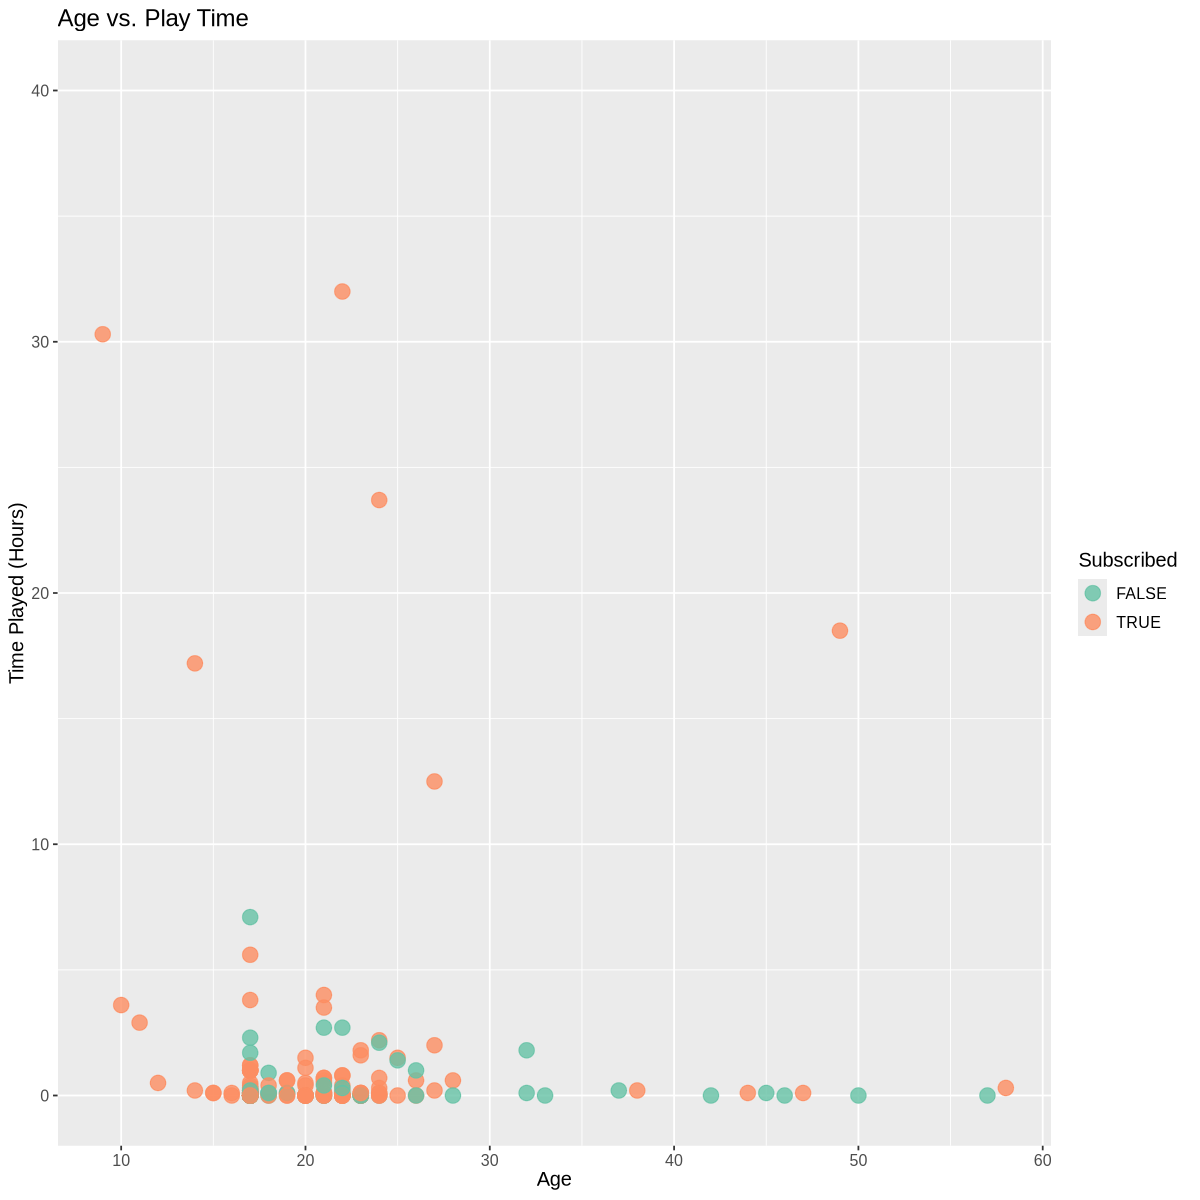

In [4]:
#Make exploratory visualizations
options(repr.plot.width = 10, repr.plot.height = 10)
hours_plot <- players_data_tidy |>
    ggplot(aes(x = age, y = played_hours, color = subscribe)) + 
    geom_point(size = 4, alpha = 0.8) +
    labs(title = "Age vs. Play Time",
         x = "Age", 
         y = "Time Played (Hours)",
         color = "Subscribed") +
    ylim(0.0, 40) +
    theme(text = element_text(size = 12)) +
    scale_color_brewer(palette = "Set2")

hours_plot

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


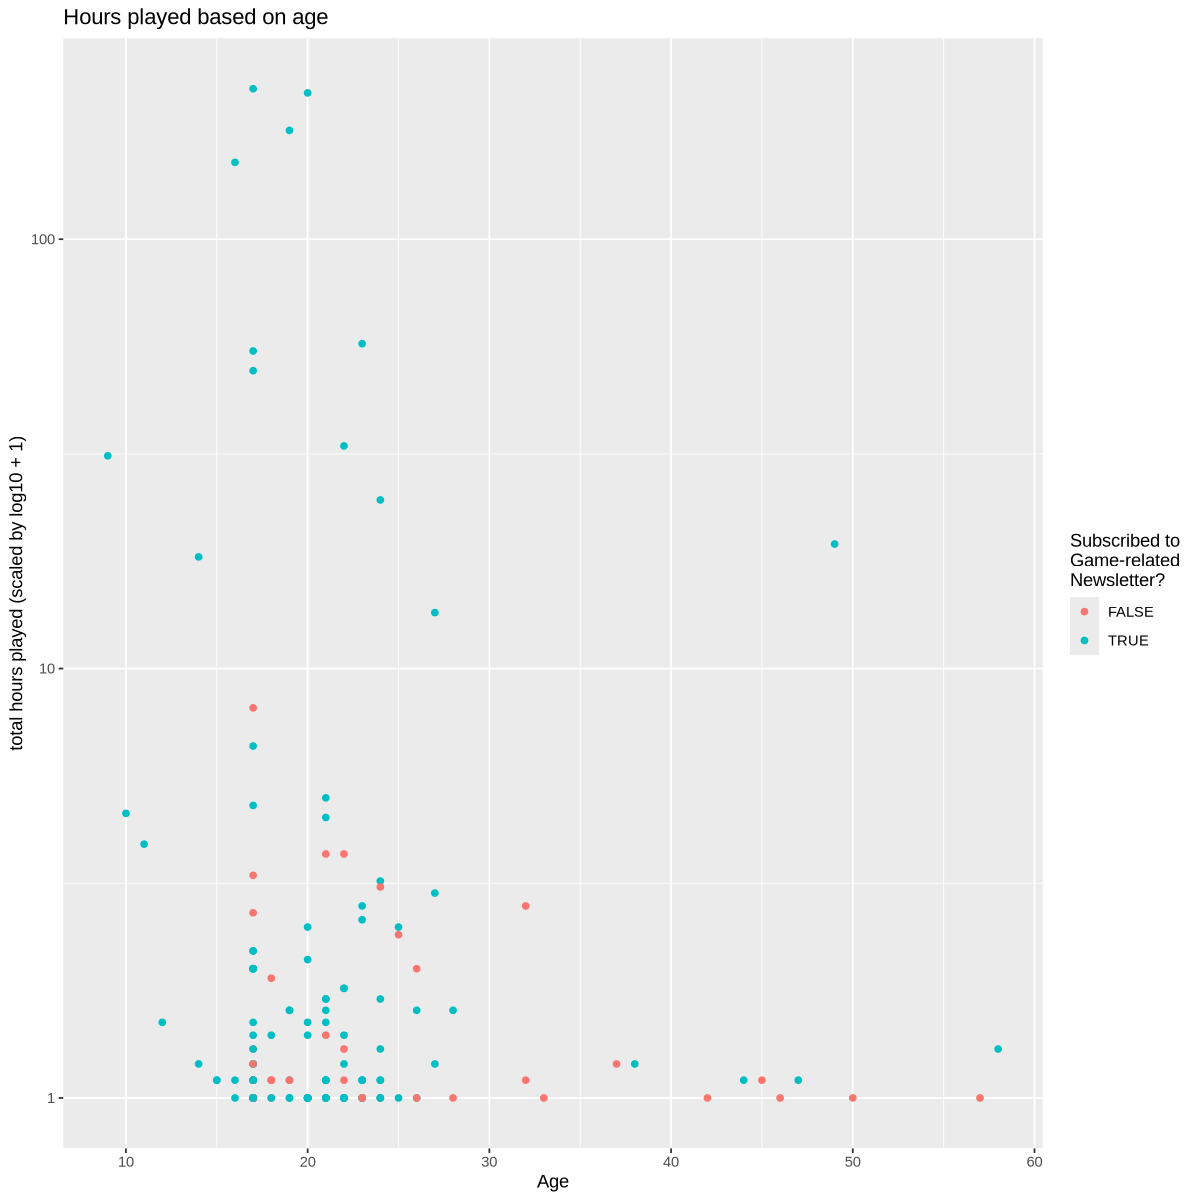

In [5]:
#this is how i did it, i wanted to avoid all removing a bunch of points that were outliers, also i feel
#this way the data is more spread out so its easier to interpret
age_hours_plot <- ggplot(players_data_tidy, aes(x = age, y = played_hours + 1, colour = subscribe)) + #avoid log(0)
                    geom_point()+
                    scale_y_log10()+
                    labs(x = "Age", y = "total hours played (scaled by log10 + 1)", colour = "Subscribed to\nGame-related\nNewsletter?")+
                    ggtitle("Hours played based on age")
age_hours_plot

(my exploratory analysis, can change this was just yapping)

The age hours plot can be our first step of thinking about this data and if there's some kind of relationship. My original thought was that as age went up, hours would go down due to less time/priorities. In the graph, we don't really see that, the hours are pretty variable in the 15-25 range. It would've been interesting if we had more data from older people to better see some kind of relationship. I scaled hours_played using log10 since there were some outliers with hundreds of hours that were really stretching out the plot, and not letting us get a good look at the rest of the points. I also added the + 1 to all hours played, since without it, our y axis would exclude data with 0 hours (since log(0) is an error). Along with that, log(1) is equal to 0 so I chose 1 as the scaling to make sure we didnt get any negative y values here. Later, when doing the classification we'll scale the age and hours in terms of standard deviations anyways so it won't matter but for this exploratory vizualization we need it. From the coloured points, we can see with higher ages, or less hours we generally see more red points compared to younger, more frequent players.

### Data analysis
#### Training/test split:
Split our data so 75% is training and the other 25% of data is saved for testing


In [6]:
players_split <- initial_split(players_data_tidy, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)
#head(players_train)
#head(players_test)

#### Recipe:
Setup a recipe, and scale the data so neither played_hours, nor age has more power when predicting

In [7]:
players_recipe <- recipe(subscribe ~ age + played_hours , data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Now to get a sense of a model predicting subscription status based on age and played_hours, pick a arbitrary k = 5 and see the accuracy

In [60]:
#knn with a set k, just to start
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5)|>
        set_engine("kknn") |>
        set_mode("classification")

#fit on the training data
players_fit <- workflow()|>
        add_recipe(players_recipe)|>
        add_model(players_spec)|>
        fit(data = players_train)

players_test_predictions <- predict(players_fit , players_test) |>
       bind_cols(players_test)

#players_test_predictions

#see how accurate our model with 5 neighbors is
players_prediction_accuracy <- players_test_predictions |>
         metrics(truth = subscribe, estimate = .pred_class)|>
            filter(.metric == "accuracy")

players_prediction_accuracy

players_mat <- players_test_predictions |> 
       conf_mat(truth = subscribe, estimate = .pred_class)

players_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6122449


          Truth
Prediction FALSE TRUE
     FALSE     6   12
     TRUE      7   24

With k = 5, we see our model is correct in it's prediction 61% of the time

In [52]:
#5 fold cross validation
# isssue arises, no matter the fold size it has this orig_rows error, may have to scrap doing validation and
# just explain why
players_vfold <- vfold_cv(players_train, v = 3, strata = subscribe)

players_resample_fit <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(players_spec) |>
       fit_resamples(resamples = players_vfold)

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 47 rows.
               ✖ Assigned data has 49 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 49 to size 47.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





In [29]:
#tune for k
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
        set_engine("kknn") |>
        set_mode("classification")


#give us a collumn of k values
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#bring everything together in a workflow
knn_results <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = players_vfold, grid = k_vals) |>
       collect_metrics()
knn_results


→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 71 rows.
               ✖ Assigned data has 73 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 73 to size 71.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6216216,1,NA,Preprocessor1_Model01
1,roc_auc,binary,0.5340909,1,NA,Preprocessor1_Model01
2,accuracy,binary,0.6216216,1,NA,Preprocessor1_Model02
2,roc_auc,binary,0.5262238,1,NA,Preprocessor1_Model02
3,accuracy,binary,0.6621622,1,NA,Preprocessor1_Model03
3,roc_auc,binary,0.5030594,1,NA,Preprocessor1_Model03
4,accuracy,binary,0.6621622,1,NA,Preprocessor1_Model04
4,roc_auc,binary,0.5065559,1,NA,Preprocessor1_Model04
5,accuracy,binary,0.6486486,1,NA,Preprocessor1_Model05



Talk limitations in the discussion?

**Limitations include choosing the right number of neighbors, scaling, and how far apart the points are**

- the number of neighbors chosen can change how accurate the resulting prediction is
- not scaling the axis can give innacurate results
- If many points are close together, it may be hard to predict
  


**Processing the data**
- Select variables relevant to the question asked


**Github Link**
https://github.com/Amisha-B32/individual_project_repo.git